# Laboratorium 3

Celem trzeciego laboratorium jest zapoznanie się oraz zaimplementowanie algorytmów uczenia aktywnego. Zaimplementowane algorytmy będą testowane z wykorzystaniem wcześniej przygotowanych środowisk.


Dołączenie standardowych bibliotek

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

Dołączenie bibliotek ze środowiskami

In [2]:
from env.dqnSimpleMDP import dqnSimpleMDP
from env.CliffWorldMDP import CliffWorld
from algs.QLearningAgent import QLearningAgent
from algs.Sarsa import SARSAAgent, ExpectedSARSAAgent

## Zadanie 1 - SARSA($\lambda$)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu SARSA($\lambda$). Algorytm aktualizuje funkcję wartości stanu-akcji dla każdej odwiedzonej pary stan-akcja zgodnie ze wzorem:
\begin{equation}
    Q_{t + 1}(s, a) = Q_t(s, a) + \alpha \delta_t E_t(s, a)
\end{equation}
gdzie:
    
- $\delta_t = r_{t + 1} \gamma Q_t(s_{t + 1}, a_{t + 1}) - Q_t(s_{t}, a_{t})$,
    
- $E_t(s, a)$ - ślad dla pary stan - akcja w chwili czasowej $t$, zwiększany o $1$ w chwili odwiedzenia danego stanu.
- Et(s, a) = (1 − α)γλEt−1(s, a) + 1 - ang. dutch traces.

</p>

In [3]:
import random
from collections import defaultdict


class SARSALambdaAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions, lambda_value):
        """
        SARSA Lambda Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.lambda_value = lambda_value

        self.odwiedzone_stany = set()

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def reset(self):
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))

    # ---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #
        # INSERT CODE HERE to get maximum possible value for a given state
        #
        values =[]
        for action in possible_actions:
            values.append(self.get_qvalue(state,action))

        return max(values)

    def update(self, state, action, reward, next_state):
        """
        You should do your SARSA-Lambda update here:
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value in the state for the action 
        #
        #display_qvalues()

        #dodajmy stan do listy odwidzonych
        self.odwiedzone_stany.add(state)

        next_action = self.get_action(next_state)

        #δt = rt+1γQt(st+1, at+1) − Qt(st, at).
        delta_chyba = reward  + gamma * self.get_qvalue(next_state,next_action) - self.get_qvalue(state,action)
        #Et(s, a) = (1 − α)γλEt−1(s, a) + 1   dutch traces
        self._evalues[state][action] = (1 - learning_rate)*gamma*self.lambda_value*self._evalues[state][action] + 1

        for s in self.odwiedzone_stany:#i teraz przechodzimy po wszytkich odwidzonych stanach i aktaulaizjumy jak we wzorze
            for a in self.get_legal_actions(state):
                pokrecona_reszta=learning_rate * self._evalues[s][a] * delta_chyba
                value = self.get_qvalue(s,a) + pokrecona_reszta                                 # SLAJD 53
                self.set_qvalue(s,a,value)
                self._evalues[s][a] = gamma * self.lambda_value * self._evalues[s][a]        


        return next_action

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best action for a given state
        #
        #
        best_value = self.get_qvalue(state,possible_actions[0])
        best_act = [possible_actions[0]]
        for i in range(1,len(possible_actions)):            
            temp = self.get_qvalue(state,possible_actions[i])
            if temp > best_value:
                best_act = [possible_actions[i]]
                best_value = temp
            elif temp == best_value:
                best_act.append(possible_actions[i])

        best_action = random.choice(best_act)

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #
        if random.random()<epsilon:
            chosen_action = random.choice(possible_actions)  
        else:   
            chosen_action = self.get_best_action(state)         

        return chosen_action

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0

    def display_qvalues(self):
        for s in self._qvalues:
            print("State: " + str(s) + " " + str(self._qvalues[s]))


 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [4]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()

    done = False

    agent.reset()
    action = agent.get_action(state)
    
    while not done:
        # get agent to pick action given state state.

        next_state, reward, done, _ = env.step(action)

        # train (update) agent for state
        action = agent.update(state,action,reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break
    return total_reward

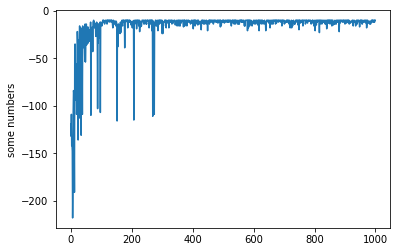

In [5]:
environment = CliffWorld()
agent = SARSALambdaAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=environment.get_possible_actions, lambda_value = 0.5)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent))

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

## Zadanie 2 - Double Q-Learning

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Double Q-Learning. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorami:
    \begin{equation*}
        Q_1(s_t, a_t) = Q_1(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_2(s_{t + 1}, argmax_a(Q_1(s_{t + 1}, a))) - Q_1(s_t, a_t)]
    \end{equation*}
    \begin{equation*}
        Q_2(s_t, a_t) = Q_2(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_1(s_{t + 1}, argmax_a(Q_2(s_{t + 1}, a))) - Q_2(s_t, a_t)]
    \end{equation*}
z prawdopodobieństwem wyboru każdej z opcji równym 50%.
</p>

In [6]:
import random
from collections import defaultdict


class DQLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Double Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)
        """

        self.get_legal_actions = get_legal_actions
        self._qvaluesA = defaultdict(lambda: defaultdict(lambda: 0))
        self._qvaluesB = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        
    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvaluesA[state][action] + self._qvaluesB[state][action] 


    #---------------------START OF YOUR CODE---------------------#
    def get_qvalueA(self, state, action):
        """ Returns Q(state,action) """
        return self._qvaluesA[state][action]
    def set_qvalueA(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvaluesA[state][action] = value
    def get_qvalueB(self, state, action):
        """ Returns Q(state,action) """
        return self._qvaluesB[state][action]
    def set_qvalueB(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvaluesB[state][action] = value
    
    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value in the state for the action 
        #

        if random.choice(['A','B']) == 'A':
            best_action = self.get_best_action(next_state,'A')#dla A
            valueA = (1-learning_rate)*self.get_qvalueA(state,action) + learning_rate*(reward+gamma*self.get_qvalueB(next_state,best_action))
            self.set_qvalueA(state,action,valueA)
        else:
            best_action = self.get_best_action(next_state,'B')#dla B
            valueB = (1-learning_rate)*self.get_qvalueB(state,action) + learning_rate*(reward+gamma*self.get_qvalueA(next_state,best_action))       
            self.set_qvalueB(state,action,valueB)

    def get_best_action(self, state, AorB):#slajd 31
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        if AorB == 'A':
            get_qvalue = self.get_qvalueA
        elif AorB == 'B':
            get_qvalue = self.get_qvalueB
        elif AorB == 'AandB':
            get_qvalue = self.get_qvalue

        best_value = get_qvalue(state,possible_actions[0])
        best_act = [possible_actions[0]]
        for i in range(1,len(possible_actions)):            
            temp = get_qvalue(state,possible_actions[i])
            if temp > best_value:
                best_act = [possible_actions[i]]
                best_value = temp
            elif temp == best_value:
                best_act.append(possible_actions[i])
        best_action = random.choice(best_act)

        return best_action


    def get_action(self, state):
        possible_actions = self.get_legal_actions(state) 
        if len(possible_actions) == 0:
            return None
        epsilon = self.epsilon
        if random.random()<epsilon:
            chosen_action = random.choice(possible_actions)
        else:   
            chosen_action = self.get_best_action(state,'AandB') 

        return chosen_action

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0


In [7]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()

    done = False

    while not done:
        # get agent to pick action given state state.
        action = agent.get_action(state)

        next_state, reward, done, _ = env.step(action)#przejście do nastpenego stanu

        #
        # INSERT CODE HERE to train (update) agent for state
        #        
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward

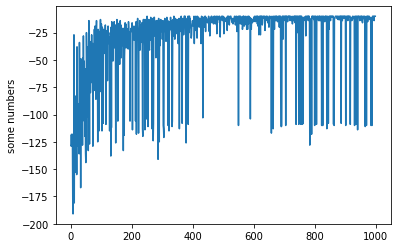

In [8]:
environment = CliffWorld()
agent = DQLearningAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       get_legal_actions=environment.get_possible_actions)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent))

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

In [9]:
env = dqnSimpleMDP()

max_tests = 10000
n_eps = 300
eps = 0.1
lr = 0.1


left_count_q = np.zeros(n_eps) #count left choices in state A for algorithm Q-Learning
left_count_dq = np.zeros(n_eps) #count left choices in state A for algorithm Double Q-Learning

q_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Q-Learning
dq_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning


In [10]:

t = 0
s_1 = None
while t < max_tests:

    Q = {state: np.zeros(env.max_actions) for state in env.state_actions.keys()}
    agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                           get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_q[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                q_estimate[ep] += agent.get_qvalue('A', 1)

                break
    t += 1

q_estimate /= max_tests

In [11]:
t = 0
while t < max_tests:

    agent = DQLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_dq[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                dq_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

dq_estimate /= max_tests

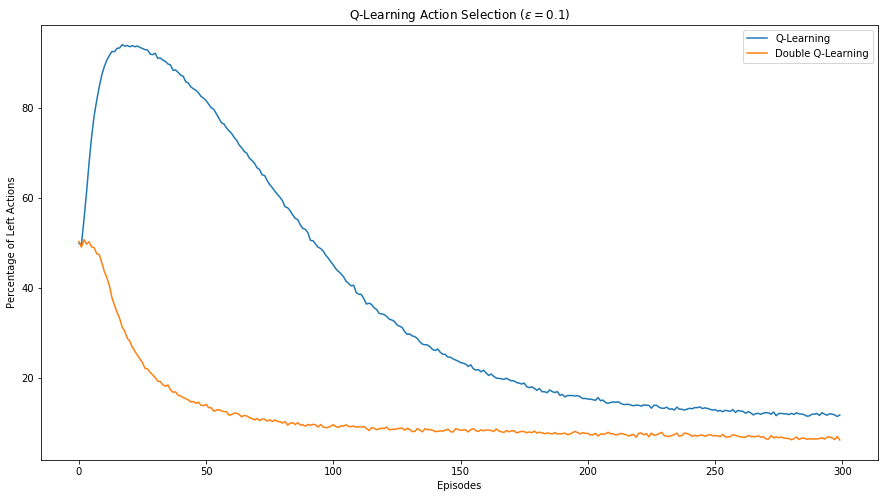

In [12]:
plt.figure(figsize=(15,8))
plt.plot(left_count_q/max_tests*100,
         label='Q-Learning')
plt.plot(left_count_dq/max_tests*100,
          label='Double Q-Learning')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()




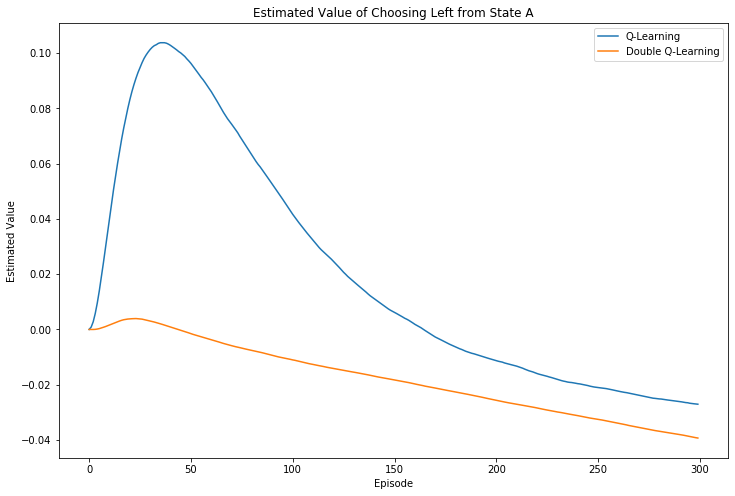

In [13]:
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-Learning')
plt.plot(dq_estimate, label='Double Q-Learning')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()

## Zadanie 3 

Przetestuj działanie wszystkich zaimplementowanych algorytmów w środowisku dqnSimpleMDP, który algorytm działa najlepiej?

In [14]:
left_count_sars = np.zeros(n_eps) #count left choices in state A for algorithm Q-Learning
left_count_expected_sars = np.zeros(n_eps) #count left choices in state A for algorithm Double Q-Learning
sars_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Q-Learning
expected_sars_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning
lambda_sars_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning
left_count_lambda_sars = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning

In [15]:
t = 0#sars
while t < max_tests:

    agent = SARSAAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        # Select eps-greedy action
        action = agent.get_action(state)
        while True:
            # # Select eps-greedy action
            # action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_sars[ep] += 1

            next_state, reward, done, _ = env.step(action)

            action = agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                sars_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

sars_estimate /= max_tests

In [16]:
t = 0#expecteed sars
while t < max_tests:

    agent = ExpectedSARSAAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_expected_sars[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                expected_sars_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

expected_sars_estimate /= max_tests

In [17]:
t = 0#lambda sars
while t < max_tests:

    agent = SARSALambdaAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions, lambda_value = 0.5)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_lambda_sars[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                lambda_sars_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

lambda_sars_estimate /= max_tests

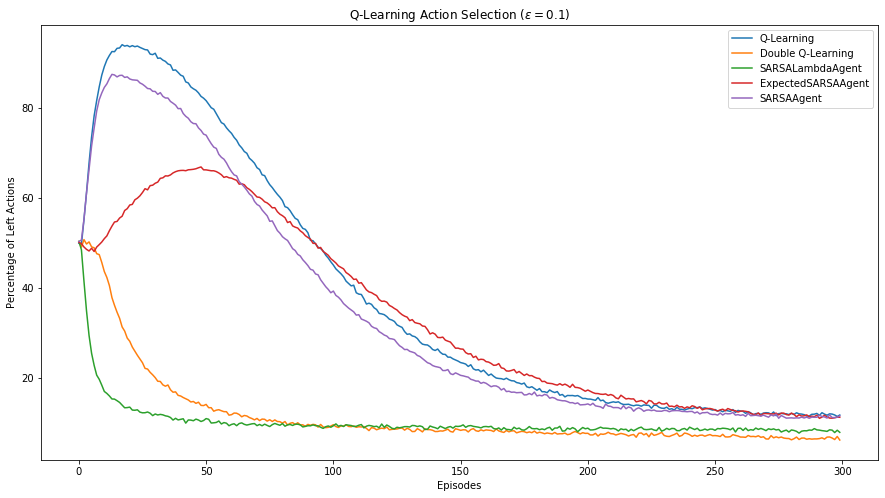

In [18]:
plt.figure(figsize=(15,8))
plt.plot(left_count_q/max_tests*100,
         label='Q-Learning')
plt.plot(left_count_dq/max_tests*100,
          label='Double Q-Learning')
plt.plot(left_count_lambda_sars/max_tests*100,
          label='SARSALambdaAgent')
plt.plot(left_count_expected_sars/max_tests*100,
          label='ExpectedSARSAAgent')
plt.plot(left_count_sars/max_tests*100,
          label='SARSAAgent')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()


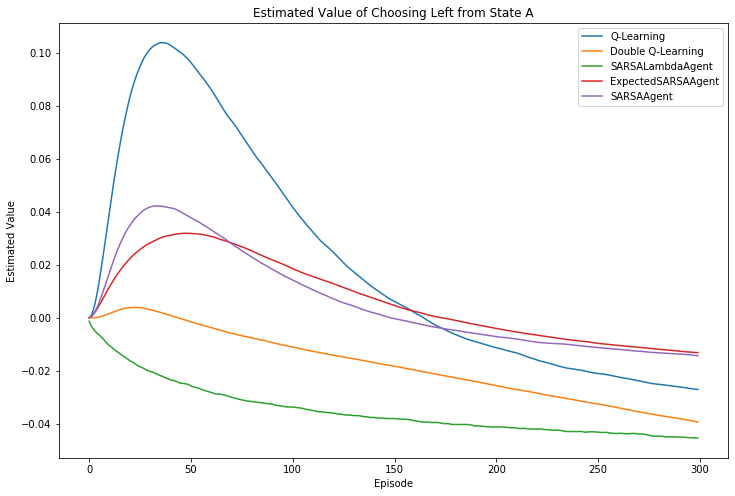

In [19]:
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-Learning')
plt.plot(dq_estimate, label='Double Q-Learning')
plt.plot(lambda_sars_estimate, label='SARSALambdaAgent')
plt.plot(expected_sars_estimate, label='ExpectedSARSAAgent')
plt.plot(sars_estimate,          label='SARSAAgent')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()